# 0. Preparation

## 0.1. Imports

In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gc

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, classification_report



## 0.2. Load Dataset

In [ ]:
def Load_Data_Frame (df_name):
  file_path = '/content/drive/MyDrive/datasources/Time Series/' + df_name + '.csv'
  data_frame = pd.read_csv(file_path)
  return data_frame

# 1. Preprocessing Functions

## 1.0. General Preprocessing

### 1.0.1. Encoding

In [ ]:
def one_hot_encode_columns(train_df, test_df, columns_to_encode, drop_first=True):
    """
    Performs one-hot encoding on multiple columns efficiently, fitting on training data
    and transforming both training and test dataframes.

    Args:
        train_df (pd.DataFrame): The training DataFrame.
        test_df (pd.DataFrame): The testing DataFrame.
        columns_to_encode (list): List of column names to be encoded.
        drop_first (bool): Whether to drop the first category to avoid multicollinearity.

    Returns:
        tuple: (encoded_train_df, encoded_test_df)
    """
    # Make explicit copies to avoid SettingWithCopyWarning
    train_df = train_df.copy()
    test_df = test_df.copy()

    for col in columns_to_encode:
        print(f"Encoding {col}...")

        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first' if drop_first else None)
        encoder.fit(train_df[[col]])

        # Get feature names
        feature_names = encoder.get_feature_names_out([col])

        # Transform and assign directly to avoid concat
        train_encoded = encoder.transform(train_df[[col]])
        test_encoded = encoder.transform(test_df[[col]])

        # Add new columns directly (more efficient than concat)
        for i, feature_name in enumerate(feature_names):
            train_df[feature_name] = train_encoded[:, i]
            test_df[feature_name] = test_encoded[:, i]

        # Drop original column
        train_df.drop(columns=[col], inplace=True)
        test_df.drop(columns=[col], inplace=True)

        # Clean up
        del train_encoded, test_encoded, encoder
        gc.collect()

        print(f"  {col} done. Train shape: {train_df.shape}")

    return train_df, test_df


In [ ]:
def ordinal_encode_column(train_df, test_df, column_name, categories='auto'):
    """
    Performs ordinal encoding on a specified column, fitting on the training data
    and transforming both training and test dataframes.

    Args:
        train_df (pd.DataFrame): The training DataFrame.
        test_df (pd.DataFrame): The testing DataFrame.
        column_name (str): The name of the column to be encoded.
        categories (list of lists or 'auto'): Categories (unique values) in the order
                                              they should be encoded. If 'auto',
                                              categories are inferred from the data.
                                              Example: [['low', 'medium', 'high']]

    Returns:
        tuple: A tuple containing two pd.DataFrames:
               - The training DataFrame with the specified column ordinal encoded.
               - The testing DataFrame with the specified column ordinal encoded.
    """
    # Initialize OrdinalEncoder
    encoder = OrdinalEncoder(categories=categories, handle_unknown='use_encoded_value', unknown_value=-1)

    # Fit the encoder ONLY on the training data
    encoder.fit(train_df[[column_name]])

    # Transform training data
    encoded_train_data = encoder.transform(train_df[[column_name]])
    train_df_encoded = train_df.copy()
    train_df_encoded[column_name] = encoded_train_data

    # Transform test data using the SAME fitted encoder
    encoded_test_data = encoder.transform(test_df[[column_name]])
    test_df_encoded = test_df.copy()
    test_df_encoded[column_name] = encoded_test_data

    return train_df_encoded, test_df_encoded

### 1.0.2. Scaling

In [ ]:
def min_max_scale_columns(train_df, test_df, columns_to_scale):
    """
    Performs Min-Max scaling on multiple columns efficiently, fitting on training data
    and transforming both training and test dataframes.

    Args:
        train_df (pd.DataFrame): The training DataFrame.
        test_df (pd.DataFrame): The testing DataFrame.
        columns_to_scale (list): List of column names to be scaled.

    Returns:
        tuple: (scaled train_df, scaled test_df)
    """
    scaler = MinMaxScaler()
    scaler.fit(train_df[columns_to_scale_minmax])

    train_df[columns_to_scale_minmax] = scaler.transform(train_df[columns_to_scale_minmax])
    test_df[columns_to_scale_minmax] = scaler.transform(test_df[columns_to_scale_minmax])

    return train_df, test_df

In [ ]:
def standard_scale_column(train_df, test_df, columns_to_scale):
    """
    Performs Standard scaling (Z-score normalization) on a specified column,
    fitting on the training data and transforming both training and test dataframes.

    Args:
        train_df (pd.DataFrame): The training DataFrame.
        test_df (pd.DataFrame): The testing DataFrame.
        columns_to_scale (str): The list of the columns to be scaled.

    Returns:
        tuple: A tuple containing two pd.DataFrames:
               - The training DataFrame with the specified column scaled.
               - The testing DataFrame with the specified column scaled.
    """
    # Initialize StandardScaler
    scaler = StandardScaler()

    # Fit the scaler ONLY on the training data
    scaler.fit(train_df[[columns_to_scale]])

    # Transform data
    train_df[columns_to_scale] = scaler.transform(train_df[[columns_to_scale]])
    test_df[columns_to_scale] = scaler.transform(test_df[[columns_to_scale]])

    return train_df, test_df

### 1.0.3. Feature Engineering

In [ ]:
def create_lag_features(X_train, columns_to_lag, lag_periods):
    """
    Creates lag features for multiple columns efficiently.

    Args:
        X_train (pd.DataFrame): The training DataFrame.
        columns_to_lag (list): List of column names to create lags for.
        lag_periods (list): List of lag periods (e.g., [1, 7, 14, 30]).

    Returns:
        pd.DataFrame: DataFrame with lag features added.
    """
    X_train_with_lags = X_train.copy()  # Only ONE copy

    for column_name in columns_to_lag:
        for lag in lag_periods:
            X_train_with_lags[f'{column_name}_lag_{lag}'] = X_train_with_lags[column_name].shift(lag)

    return X_train_with_lags

## 1.1. Preprocessing for ARIMA

In [ ]:
def plot_arima_diagnostics(df, time_column, target_column, lags=20, figsize=(15, 10)):
    """
    Generates diagnostic plots for ARIMA model selection including:
    1. Time series plot
    2. Autocorrelation Function (ACF) plot
    3. Partial Autocorrelation Function (PACF) plot

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        time_column (str): The name of the column containing time or date information.
        target_column (str): The name of the column containing the target variable.
        lags (int): The number of lags to display in ACF and PACF plots. Defaults to 20.
        figsize (tuple): Figure size for the plots. Defaults to (15, 10).
    """
    # Ensure the time_column is set as index if not already
    if df.index.name != time_column:
        df = df.set_index(time_column)

    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Plot 1: Time Series Plot
    axes[0].plot(df.index, df[target_column])
    axes[0].set_title(f'Time Series Plot of {target_column}')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel(target_column)

    # Plot 2: ACF Plot
    plot_acf(df[target_column], lags=lags, ax=axes[1])
    axes[1].set_title(f'Autocorrelation Function (ACF) for {target_column}')

    # Plot 3: PACF Plot
    plot_pacf(df[target_column], lags=lags, ax=axes[2])
    axes[2].set_title(f'Partial Autocorrelation Function (PACF) for {target_column}')

    plt.tight_layout()
    plt.show()


## 1.2. Preprocessing for SARIMAX

In [ ]:
def plot_sarimax_diagnostics(df, time_column, target_column, lags=20, seasonal_period=None, figsize=(15, 12)):
    print(f'Plots for the seasonal_period: {seasonal_period}')
    """
    Generates diagnostic plots for SARIMAX model selection.
    """
    # Ensure the time_column is set as index and is datetime type
    temp_df = df.copy()
    if temp_df.index.name != time_column:
        temp_df = temp_df.set_index(time_column)
    temp_df.index = pd.to_datetime(temp_df.index)

    # Determine number of subplots (excluding decomposition plot, which creates its own figure)
    # We will use 3 subplots for Time Series, ACF, and PACF
    num_plots = 3

    # Create the main figure for the 3 core plots
    fig, axes = plt.subplots(num_plots, 1, figsize=figsize)

    # Plot 1: Time Series Plot
    axes[0].plot(temp_df.index, temp_df[target_column])
    axes[0].set_title(f'Time Series Plot of {target_column}')
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel(target_column)

    # Plot 2: ACF Plot
    #
    plot_acf(temp_df[target_column], lags=lags, ax=axes[1])
    axes[1].set_title(f'Autocorrelation Function (ACF) for {target_column}')

    # Plot 3: PACF Plot
    #
    plot_pacf(temp_df[target_column], lags=lags, ax=axes[2])
    axes[2].set_title(f'Partial Autocorrelation Function (PACF) for {target_column}')

    plt.tight_layout()
    plt.show() # Show the first figure (TS, ACF, PACF)

    print('Seasonal Period:')
    # Plot 4 (Optional): Seasonal Decomposition
    # 3. Plot 4 (Optional): Seasonal Decomposition - Creates a separate, sized figure
    if seasonal_period is not None:
        try:
            # Data must be stationary (no NaNs) for decomposition
            data_to_decompose = temp_df[target_column].dropna()

            # Check for sufficient data
            if len(data_to_decompose) < 2 * seasonal_period:
                 raise ValueError(f"Not enough data ({len(data_to_decompose)} obs) for 2 full cycles with period={seasonal_period}.")

            decomposition = seasonal_decompose(
                data_to_decompose,
                model='additive',
                period=seasonal_period
            )

            # 🛑 FINAL FIX 2: Manually plot components to force figsize
            fig, axes_decomp = plt.subplots(4, 1, figsize=figsize, sharex=True)

            axes_decomp[0].plot(decomposition.observed)
            axes_decomp[0].set_ylabel('Observed')
            axes_decomp[0].set_title(f'Seasonal Decomposition (Period={seasonal_period})')

            axes_decomp[1].plot(decomposition.trend)
            axes_decomp[1].set_ylabel('Trend')

            axes_decomp[2].plot(decomposition.seasonal)
            axes_decomp[2].set_ylabel('Seasonal')

            axes_decomp[3].plot(decomposition.resid)
            axes_decomp[3].set_ylabel('Residual')

            plt.tight_layout()
            plt.show() # Show the second figure (Decomposition)

        except Exception as e:
            print(f"\nWarning: Could not perform seasonal decomposition with period={seasonal_period}: {e}")
            print("Ensure your data has at least two full seasonal cycles (i.e., at least 2 * seasonal_period observations) and no non-finite values.")


## 1.3. Preprocessing for XGBClassifier

# 2. Forcasting Functions

## 2.0. Error Metrics Calculation

In [ ]:
def calculate_regression_metrics(y_true, y_pred):
    """
    Calculate regression metrics in a memory-efficient manner.

    Args:
        y_true: True values (array-like)
        y_pred: Predicted values (array-like)

    Returns:
        dict: Dictionary containing MAE, MSE, and RMSLE
    """
    # Convert to numpy arrays once if needed
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Calculate errors once
    errors = y_pred - y_true

    # 1. MAE - use absolute value of pre-calculated errors
    mae = np.mean(np.abs(errors))

    # 2. MSE - square the pre-calculated errors
    mse = np.mean(errors ** 2)

    # 3. RMSLE - check bounds first before any log calculations
    if np.any(y_true < 0) or np.any(y_pred < 0):
        rmsle = np.nan
    else:
        # Calculate log errors directly without intermediate array
        # np.mean handles the calculation without storing full array
        rmsle = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSLE': rmsle
    }

## 2.1. ARIMA

In [ ]:
def run_arima_forecast(train_df, test_df, target_col, order=(5,1,0), exog_cols_train=None, exog_cols_test=None):
    """
    Runs an ARIMA (or ARIMAX) forecast based on given train and test data for a target value.

    Args:
        train_df (pd.DataFrame): Training DataFrame containing the target time series.
        test_df (pd.DataFrame): Testing DataFrame, used for determining forecast horizon.
        target_col (str): The name of the column to be forecasted.
        order (tuple): The (p,d,q) order of the ARIMA model. Default is (5,1,0).
        exog_cols_train (list or None): List of column names in train_df to use as
                                         exogenous regressors for training. If None, no exogenous
                                         variables are used.
        exog_cols_test (list or None): List of column names in test_df to use as
                                        exogenous regressors for forecasting. If None, no exogenous
                                        variables are used.

    Returns:
        pd.Series: The forecasted values for the test period.
    """

    # Ensure the target column is a Series for ARIMA
    train_series = train_df[target_col]

    train_exog = None
    test_exog = None

    if exog_cols_train:
        # Exogenous variables are used in both fitting and forecasting
        train_exog = train_df[exog_cols_train].dropna()
    if exog_cols_test:
        # Exogenous variables are used only in forecasting
        test_exog = test_df[exog_cols_test]

    # Fit ARIMA model, passing exogenous variables if provided
    model = ARIMA(train_series, order=order, exog=train_exog)
    model_fit = model.fit()

    # Forecast
    # start and end are based on the indices of the test_df
    start_index = len(train_series)
    end_index = len(train_series) + len(test_df) - 1

    # Pass exogenous variables for forecasting if provided
    forecast = model_fit.predict(start=start_index, end=end_index, exog=test_exog)
    forecast.index = test_df.index # Align index with test data

    return forecast

# Note: This function assumes that the 'train_df' and 'test_df' are properly ordered
# time series dataframes. If your data is not indexed by time or has gaps,
# additional preprocessing might be required before using this function.
# When 'exog_cols_train' and 'exog_cols_test' are provided, the model incorporates
# these exogenous regressors (ARIMAX model).

## 2.2. SARIMAX

In [ ]:
def run_sarimax_forecast(train_df, test_df, target_col, order=(5, 1, 0), seasonal_order=(0, 0, 0, 0), exog_cols_train=None, exog_cols_test=None):
    """
    Runs a SARIMAX forecast based on given train and test data for a target value,
    including options for seasonality and exogenous regressors.

    Args:
        train_df (pd.DataFrame): Training DataFrame containing the target and exogenous variables.
        test_df (pd.DataFrame): Testing DataFrame, containing exogenous variables for the forecast period.
        target_col (str): The name of the column to be forecasted (endogenous variable).
        order (tuple): The non-seasonal (p, d, q) order of the SARIMAX model. Default is (5, 1, 0).
        seasonal_order (tuple): The seasonal (P, D, Q, s) order of the model.
                                s is the seasonal period (e.g., 12 for monthly data). Default is (0, 0, 0, 0) (no seasonality).
        exog_cols (list or None): List of column names in train/test_df to use as
                                  exogenous regressors. Pass None for a pure Seasonal ARIMA (SARIMA) model.

    Returns:
        pd.Series: The forecasted values for the test period.
    """

    # --- 1. Prepare Data ---
    train_series = train_df[target_col]

    # Prepare exogenous data if specified
    train_exog = None
    test_exog = None

    if exog_cols_train:
        # Exogenous variables are used in both fitting and forecasting
        train_exog = train_df[exog_cols_train].dropna()
    if exog_cols_test:
        # Exogenous variables are used only in forecasting
        test_exog = test_df[exog_cols_test]

    # --- 2. Fit SARIMAX model ---
    model = SARIMAX(
        endog=train_series,
        exog=train_exog,        # NEW: Exogenous variables for fitting
        order=order,
        seasonal_order=seasonal_order, # NEW: Seasonal order
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    model_fit = model.fit(disp=False) # disp=False suppresses convergence output

    # --- 3. Forecast ---
    # SARIMAX requires exogenous variables (test_exog) for forecasting if they were
    # used during fitting. The start and end indices remain the same.
    start_index = len(train_series)
    end_index = len(train_series) + len(test_df) - 1

    forecast_results = model_fit.predict(
        start=start_index,
        end=end_index,
        exog=test_exog # NEW: Exogenous variables for forecasting
    )

    # Align index with test data
    forecast_results.index = test_df.index

    return forecast_results

## 2.3. XGBRegressor

In [ ]:
def run_xgboost_forecast(train_df, test_df, target_col, exog_cols_train=None, exog_cols_test=None, n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, **kwargs):
    """
    Runs an XGBoost forecast based on given train and test data for a target value.

    Args:
        train_df (pd.DataFrame): Training DataFrame containing the target and feature variables.
        test_df (pd.DataFrame): Testing DataFrame containing feature variables for the forecast period.
        target_col (str): The name of the column to be forecasted (target variable).
        exog_cols_train (list or None): List of column names in train_df to use as features for training.
                                        Must not be empty if used (XGBoost requires features).
        exog_cols_test (list or None): List of column names in test_df to use as features for forecasting.
                                       Must not be empty if used.
        n_estimators (int): Number of boosting rounds. Default is 100.
        learning_rate (float): Learning rate (eta). Default is 0.1.
        max_depth (int): Maximum tree depth. Default is 6.
        random_state (int): Random seed for reproducibility. Default is 42.
        **kwargs: Additional parameters to pass to XGBRegressor.

    Returns:
        pd.Series: The forecasted values for the test period.
    """

    X_train = train_df[exog_cols_train]
    y_train = train_df[target_col]
    X_test = test_df[exog_cols_test]

    # --- 2. Fit XGBoost model ---
    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        random_state=random_state,
        **kwargs
    )

    model.fit(X_train, y_train)

    # --- 3. Forecast ---
    forecast_values = model.predict(X_test)

    # Convert to Series and align index with test data
    forecast_results = pd.Series(forecast_values, index=test_df.index)

    return forecast_results

## 2.4. Prophet

In [ ]:
def run_prophet_forecast(train_df, test_df, time_col, target_col):
    """
    Runs a Prophet forecast based on given train and test data for a target value.

    Args:
        train_df (pd.DataFrame): Training DataFrame containing the target time series.
        test_df (pd.DataFrame): Testing DataFrame, used for determining forecast horizon.
        time_col (str): The name of the column containing time or date information (e.g., 'date').
                        This will be mapped to 'ds' for Prophet.
        target_col (str): The name of the column to be forecasted (e.g., 'unit_sales').
                          This will be mapped to 'y' for Prophet.

    Returns:
        pd.Series: The forecasted values for the test period.
    """

    # Prepare data for Prophet: Prophet expects columns named 'ds' (datestamp) and 'y' (value)
    prophet_train_df = train_df[[time_col, target_col]].rename(columns={time_col: 'ds', target_col: 'y'})

    # Initialize and fit Prophet model
    model = Prophet()
    model.fit(prophet_train_df)

    # Create a DataFrame with future dates to predict
    # Prophet's `make_future_dataframe` is useful, but for aligning with `test_df`
    # we will use the dates from `test_df` directly.
    future_dates = pd.DataFrame({time_col: test_df[time_col]})
    future_dates = future_dates.rename(columns={time_col: 'ds'})

    # Make predictions
    forecast = model.predict(future_dates)

    # Extract forecasted values for the test period and align index
    # Prophet's forecast includes 'yhat', 'yhat_lower', 'yhat_upper'
    # We typically use 'yhat' for the point forecast.
    forecast_results = forecast['yhat']
    forecast_results.index = test_df.index # Align index with test data

    return forecast_results

# 3. Run

## 3.0. Load Data Frames and General Preprocessing

### 3.0.1. Load Dataframes

Show the values (strings) to put into the upcoming list to load data.

In [ ]:
drive.mount('/content/drive')

list_of_columns = ['type_y', 'family', 'class', 'item_nbr']

for col in list_of_columns:
  file_path = '/content/drive/MyDrive/datasources/Time Series/' + col + '_names.csv'
  data_frame = pd.read_csv(file_path)
  display(data_frame)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,type_y
0,A
1,D
2,C
3,B


,family
0,HOME APPLIANCES
1,BEAUTY
2,BEVERAGES
3,DELI
4,AUTOMOTIVE
5,DAIRY
6,PET SUPPLIES
7,HOME AND KITCHEN II
8,BAKING
9,MEATS


,class
0,1320
1,3032
2,1314
3,1076
4,1116
...,...
325,2178
326,5192
327,3004
328,6257


,item_nbr
0,129758
1,158789
2,314570
3,315322
4,363889
...,...
3917,2011200
3918,1971792
3919,1459067
3920,2005877


In the first list all of the strings from the cell before can be used if the the code from "Time Series Project EDA" as run.

df_file_names = ['GROCERY I', 'BEVERAGES', 'CLEANING']

Loads the data frames for the 3 families with the most unique items.

In [ ]:
# standard list for the given task:
df_file_names = ['GROCERY I', 'BEVERAGES', 'CLEANING']

dfs = {}

for name in df_file_names:
  dfs[name] = Load_Data_Frame(name)




In [ ]:
df = pd.concat(dfs.values(), ignore_index=True)
df = df.sort_values(by='date').reset_index(drop=True)

In [ ]:
df.columns

Index(['date', 'item_nbr', 'unit_sales', 'onpromotion', 'type_x', 'locale',
       'transferred', 'family', 'class', 'perishable', 'dcoilwtico', 'city',
       'type_y', 'cluster', 'transactions', 'day_of_week', 'day_of_month',
       'day_month'],
      dtype='object')

In [ ]:
df.drop(columns=['item_nbr'], inplace=True)

In [ ]:
df.head()

,date,unit_sales,onpromotion,type_x,locale,transferred,family,class,perishable,dcoilwtico,city,type_y,cluster,transactions,day_of_week,day_of_month,day_month
0,2013-01-02,8.0,0.0,Work Day,National,False,GROCERY I,1045,0,93.14,Quito,D,13,2111.0,2.0,2.0,NaN
1,2013-01-02,7.0,0.0,Work Day,National,False,CLEANING,3024,0,93.14,Quito,D,13,2143.0,NaN,NaN,NaN
2,2013-01-02,10.0,0.0,Work Day,National,False,CLEANING,3034,0,93.14,Quito,D,13,2143.0,NaN,NaN,NaN
3,2013-01-02,6.0,0.0,Work Day,National,False,CLEANING,3034,0,93.14,Quito,D,13,2143.0,NaN,NaN,NaN
4,2013-01-02,4.0,0.0,Work Day,National,False,CLEANING,3090,0,93.14,Quito,D,13,2143.0,NaN,NaN,NaN


### 3.0.2. General Preprocessing

#### 3.0.2.1. Aggregation

In [ ]:
def get_mode(series):
    m = series.mode()
    return m.iloc[0] if not m.empty else None

In [ ]:
agg_funcs = {
    # SUM Aggregations
    'unit_sales': 'sum',
    'transactions': 'sum',

    # MEAN (Average) Aggregations
    'onpromotion': 'mean',
    'perishable': 'mean',
    'dcoilwtico': 'mean',

    # MODE Aggregations (using the custom function)
    'type_x': get_mode,
    'locale': get_mode,
    'transferred': get_mode,
    'family': get_mode,
    'class': get_mode,
    'city': get_mode,
    'type_y': get_mode,
    'cluster': get_mode,
    'day_of_month': get_mode,
    'day_of_week': get_mode
}

In [ ]:
aggregated_df = df.groupby('date', as_index=True).agg(agg_funcs)
aggregated_df.shape

(446, 15)

In [ ]:
for col in aggregated_df.select_dtypes(include=['float64']).columns:
    aggregated_df[col] = aggregated_df[col].astype('float32')
for col in aggregated_df.select_dtypes(include=['int64']).columns:
    aggregated_df[col] = aggregated_df[col].astype('int32')


In [ ]:
agg_funcs = {
    'unit_sales': 'mean',
    'transactions': 'mean'
}
weekly_df = aggregated_df[['day_of_week', 'unit_sales', 'transactions']].copy()
monthly_df = aggregated_df[['day_of_month', 'unit_sales', 'transactions']].copy()

weekly_df = weekly_df.groupby('day_of_week', as_index=True).agg(agg_funcs)
monthly_df = monthly_df.groupby('day_of_month', as_index=True).agg(agg_funcs)

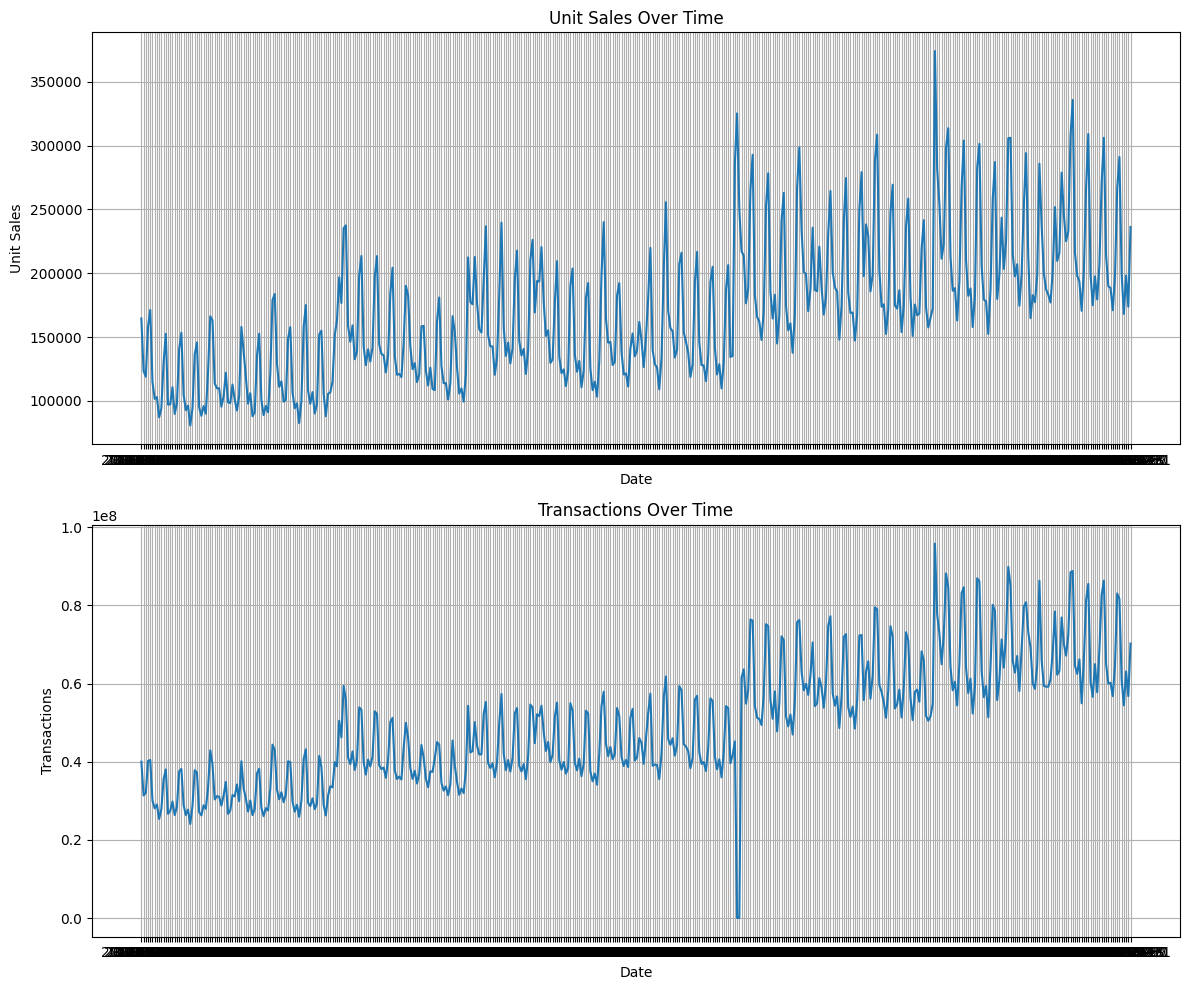

In [ ]:
# Create two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 'unit_sales' in the first subplot
sns.lineplot(x=aggregated_df.index, y='unit_sales', data=aggregated_df, ax=axes[0])
axes[0].set_title('Unit Sales Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Unit Sales')
axes[0].grid(True)

# Plot 'transactions' in the second subplot
sns.lineplot(x=aggregated_df.index, y='transactions', data=aggregated_df, ax=axes[1])
axes[1].set_title('Transactions Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Transactions')
axes[1].grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

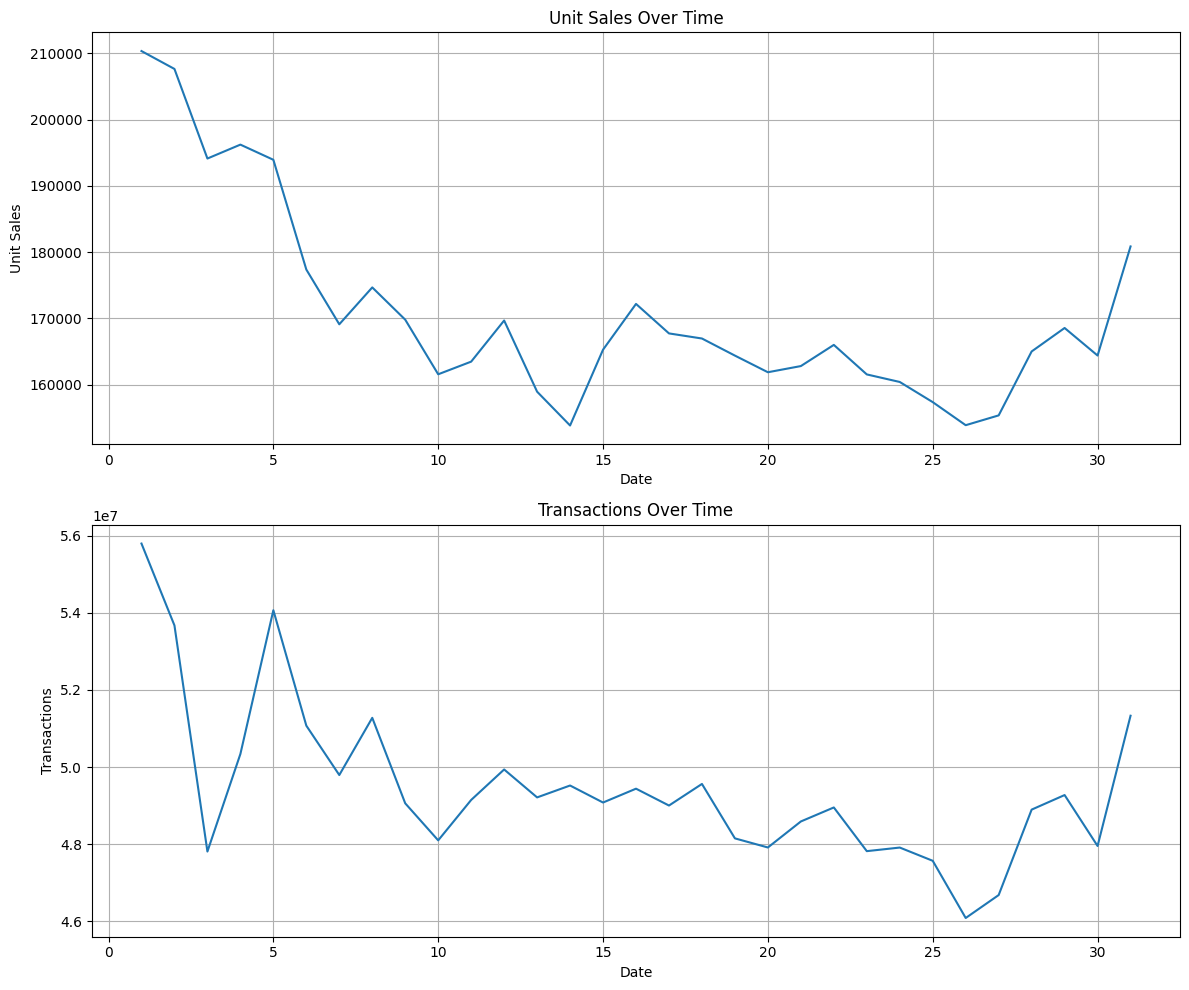

In [ ]:
# Create two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 'unit_sales' in the first subplot
sns.lineplot(x=monthly_df.index, y='unit_sales', data=monthly_df, ax=axes[0])
axes[0].set_title('Unit Sales Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Unit Sales')
axes[0].grid(True)

# Plot 'transactions' in the second subplot
sns.lineplot(x=monthly_df.index, y='transactions', data=monthly_df, ax=axes[1])
axes[1].set_title('Transactions Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Transactions')
axes[1].grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

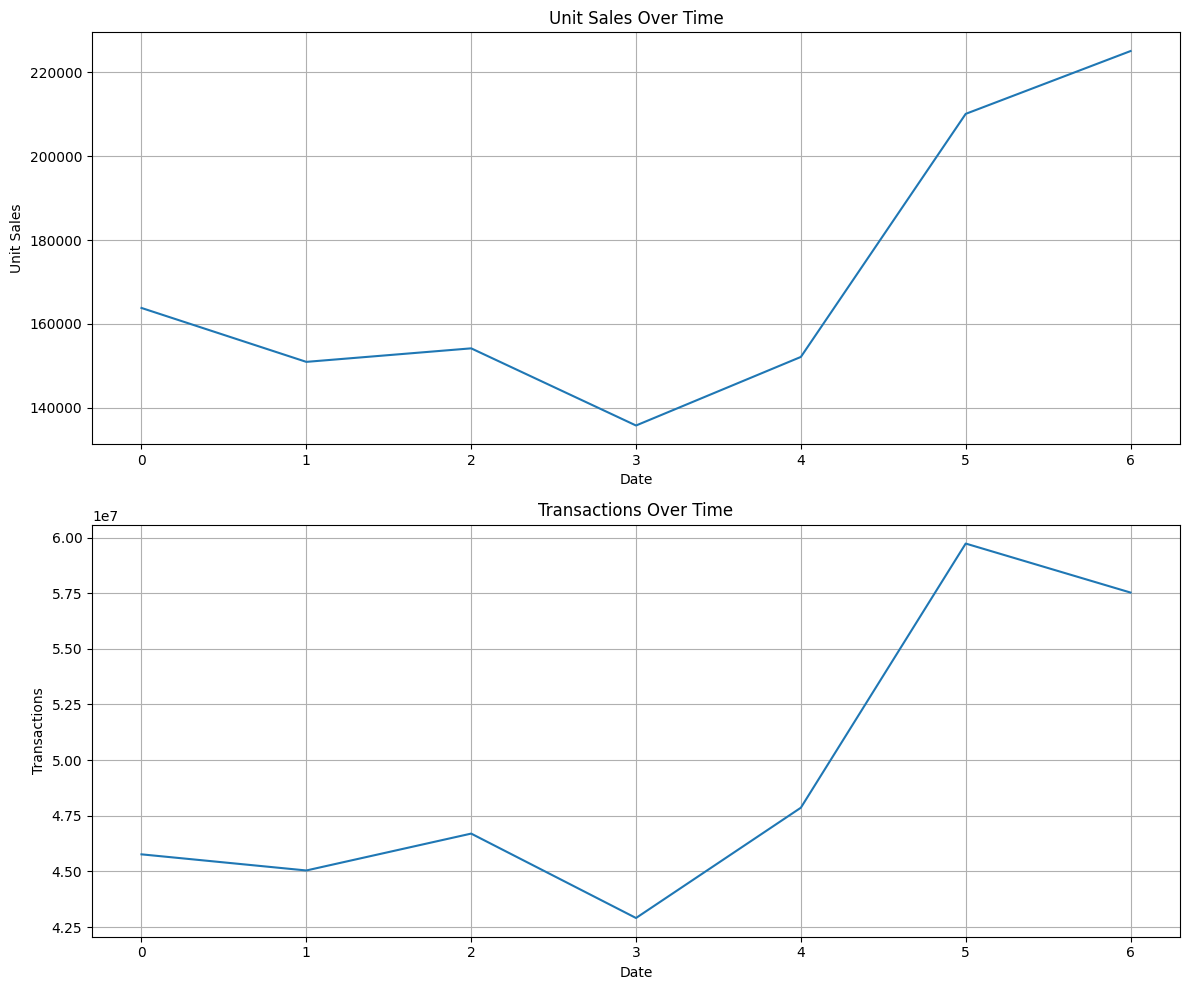

In [ ]:
# Create two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot 'unit_sales' in the first subplot
sns.lineplot(x=weekly_df.index, y='unit_sales', data=weekly_df, ax=axes[0])
axes[0].set_title('Unit Sales Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Unit Sales')
axes[0].grid(True)

# Plot 'transactions' in the second subplot
sns.lineplot(x=weekly_df.index, y='transactions', data=weekly_df, ax=axes[1])
axes[1].set_title('Transactions Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Transactions')
axes[1].grid(True)

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

#### 3.0.2.2. Splitting in Train and Test

In [ ]:
aggregated_df = aggregated_df.reset_index()
aggregated_df['date'] = pd.to_datetime(aggregated_df['date'])
split_date = '2017-01-01'
train_df = aggregated_df[aggregated_df['date'] < split_date]
test_df = aggregated_df[aggregated_df['date'] >= split_date]

print(f"Shape of training data: {train_df.shape}")
print(f"Shape of test data: {test_df.shape}")

Shape of training data: (357, 16)
Shape of test data: (89, 16)


#### 3.0.2.3. Encoding

In [ ]:
# type_x holds information about the work and holidays.
train_df['type_x'] = np.where(train_df['type_x'] == 'Work Day', 0, 1)
test_df['type_x'] = np.where(test_df['type_x'] == 'Work Day', 0, 1)

train_df['transferred'] = np.where(train_df['transferred'] == False, 0, 1)
test_df['transferred'] = np.where(test_df['transferred'] == False, 0, 1)

# class not encoded due to memory issues
columns_to_encode_onehot = ['locale', 'family', 'city', 'type_y']
train_df, test_df = one_hot_encode_columns(train_df, test_df, columns_to_encode_onehot)
print('Encoding done')

Encoding locale...


/tmp/ipython-input-2493398212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['type_x'] = np.where(train_df['type_x'] == 'Work Day', 0, 1)
/tmp/ipython-input-2493398212.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['type_x'] = np.where(test_df['type_x'] == 'Work Day', 0, 1)
/tmp/ipython-input-2493398212.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

  locale done. Train shape: (357, 15)
Encoding family...
  family done. Train shape: (357, 14)
Encoding city...
  city done. Train shape: (357, 13)
Encoding type_y...
  type_y done. Train shape: (357, 13)
Encoding done


#### 3.0.2.4. Scaling

In [ ]:
columns_to_scale_minmax = ['unit_sales', 'dcoilwtico', 'transactions']
train_df, test_df = min_max_scale_columns(train_df, test_df, columns_to_scale_minmax)

#### 3.0.2.5. Feature Engineering

In [ ]:
columns_to_lag = ['unit_sales', 'dcoilwtico']
lag_periods = [1, 7, 14, 30]
train_df = create_lag_features(train_df, columns_to_lag, lag_periods)

## 3.1. Preprocessing

### 3.1.1. ARIMA

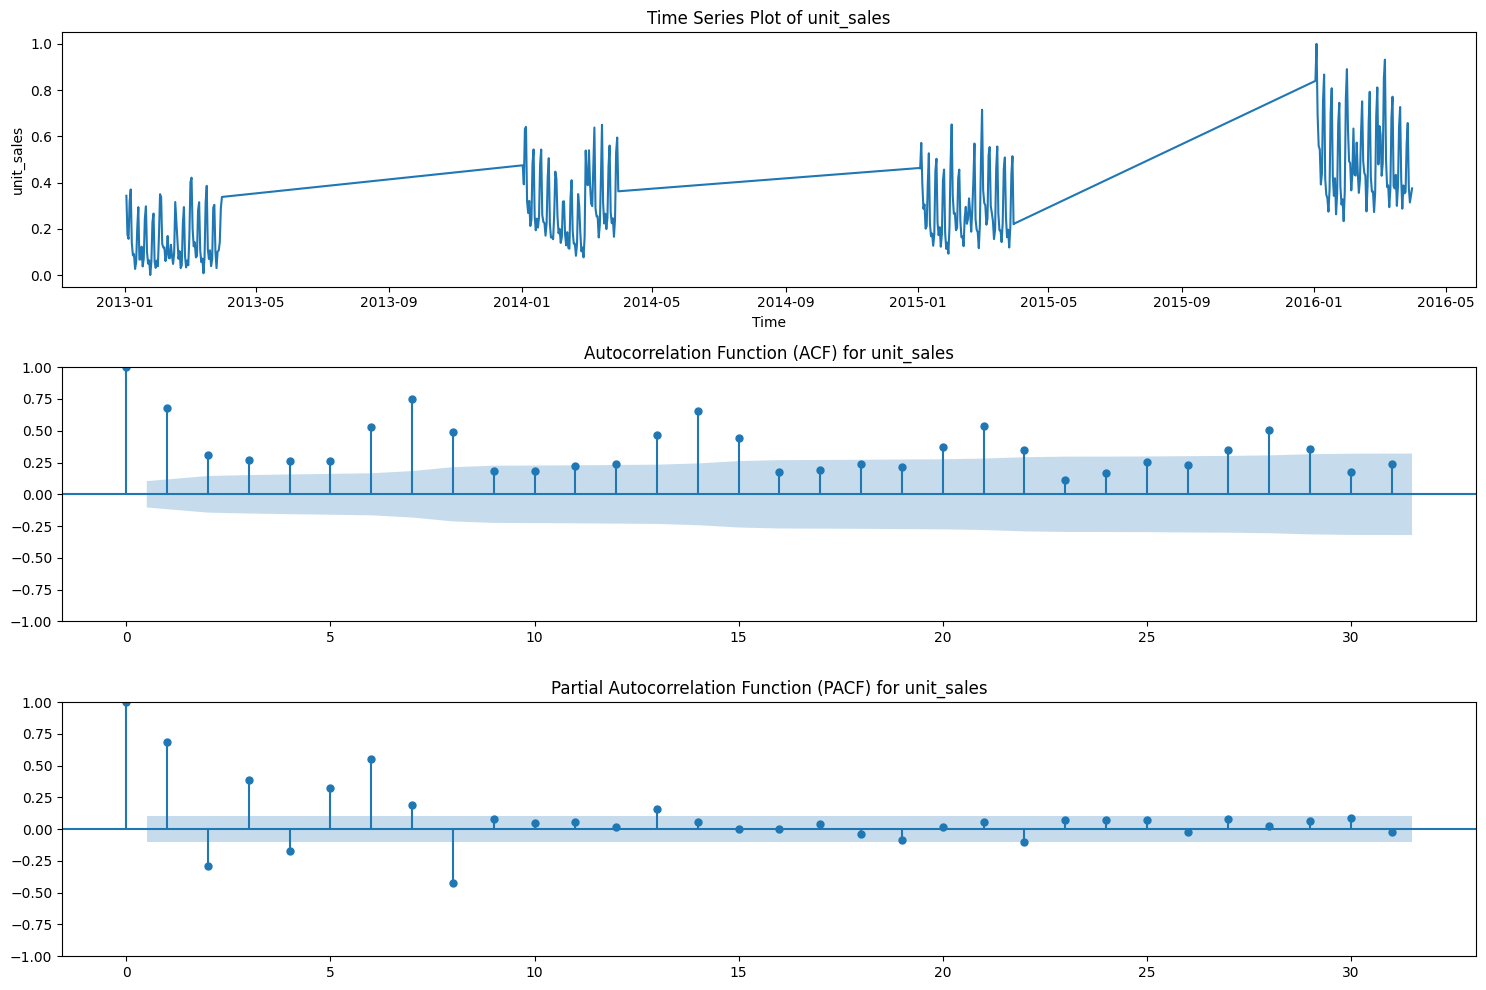

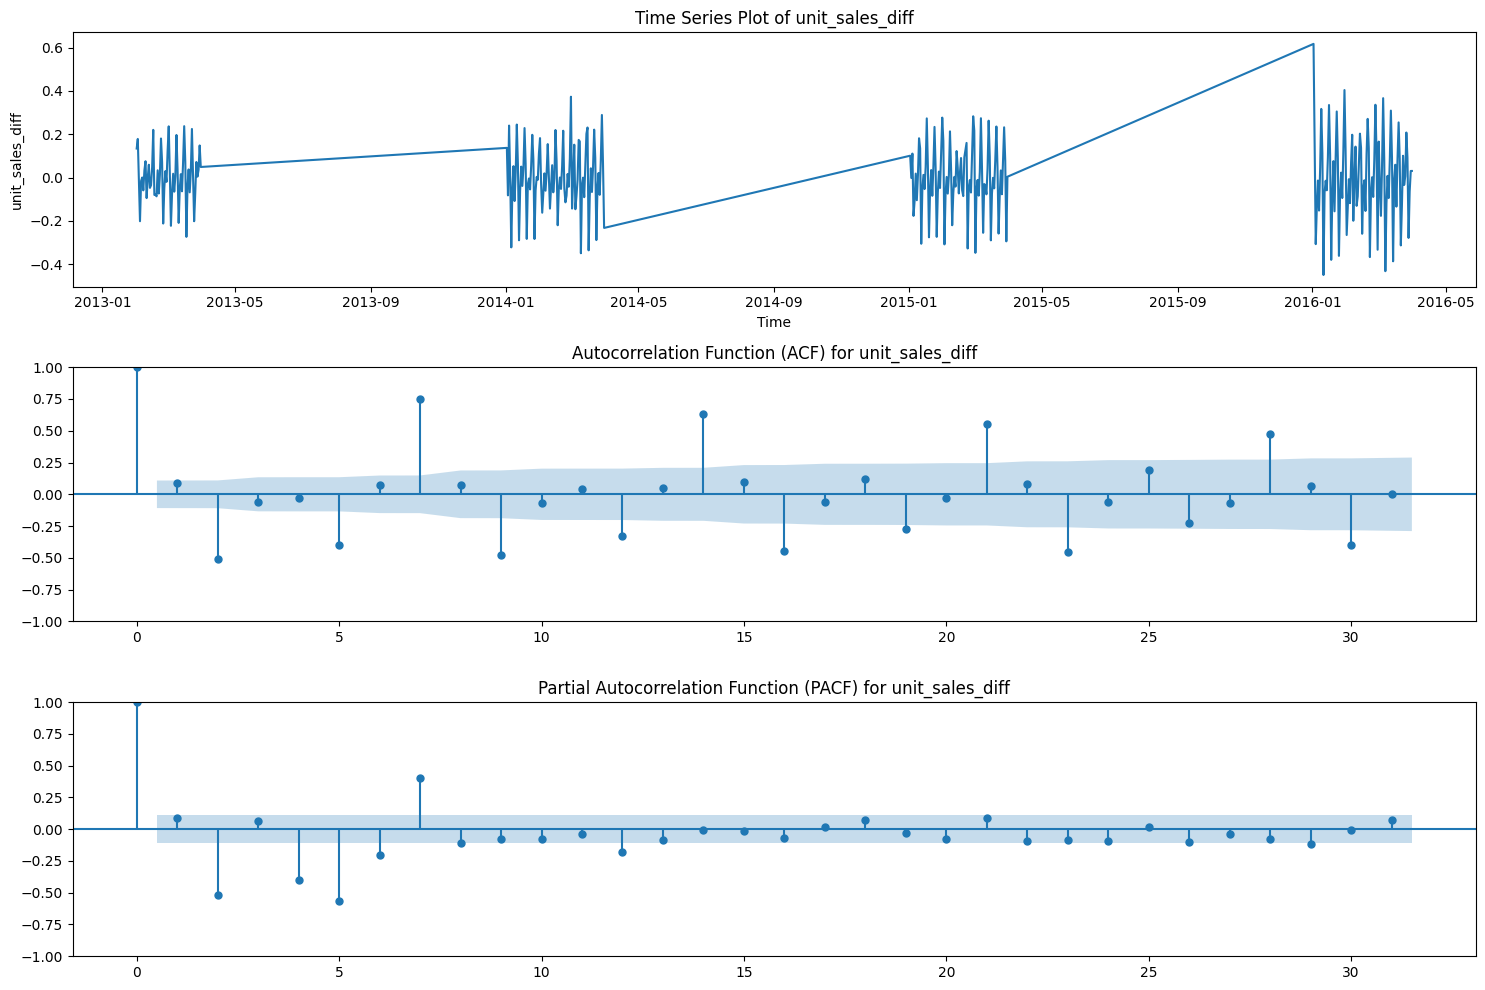

In [ ]:
plot_arima_diagnostics(train_df, 'date', 'unit_sales', lags=31)
train_df['unit_sales_diff'] = train_df['unit_sales'].diff()
plot_arima_diagnostics(train_df.dropna(), 'date', 'unit_sales_diff', lags=31)

It does show clear seasonality which makes SARIMAX the model of choice

### 3.1.2. SARIMAX

Plots for the seasonal_period: 7


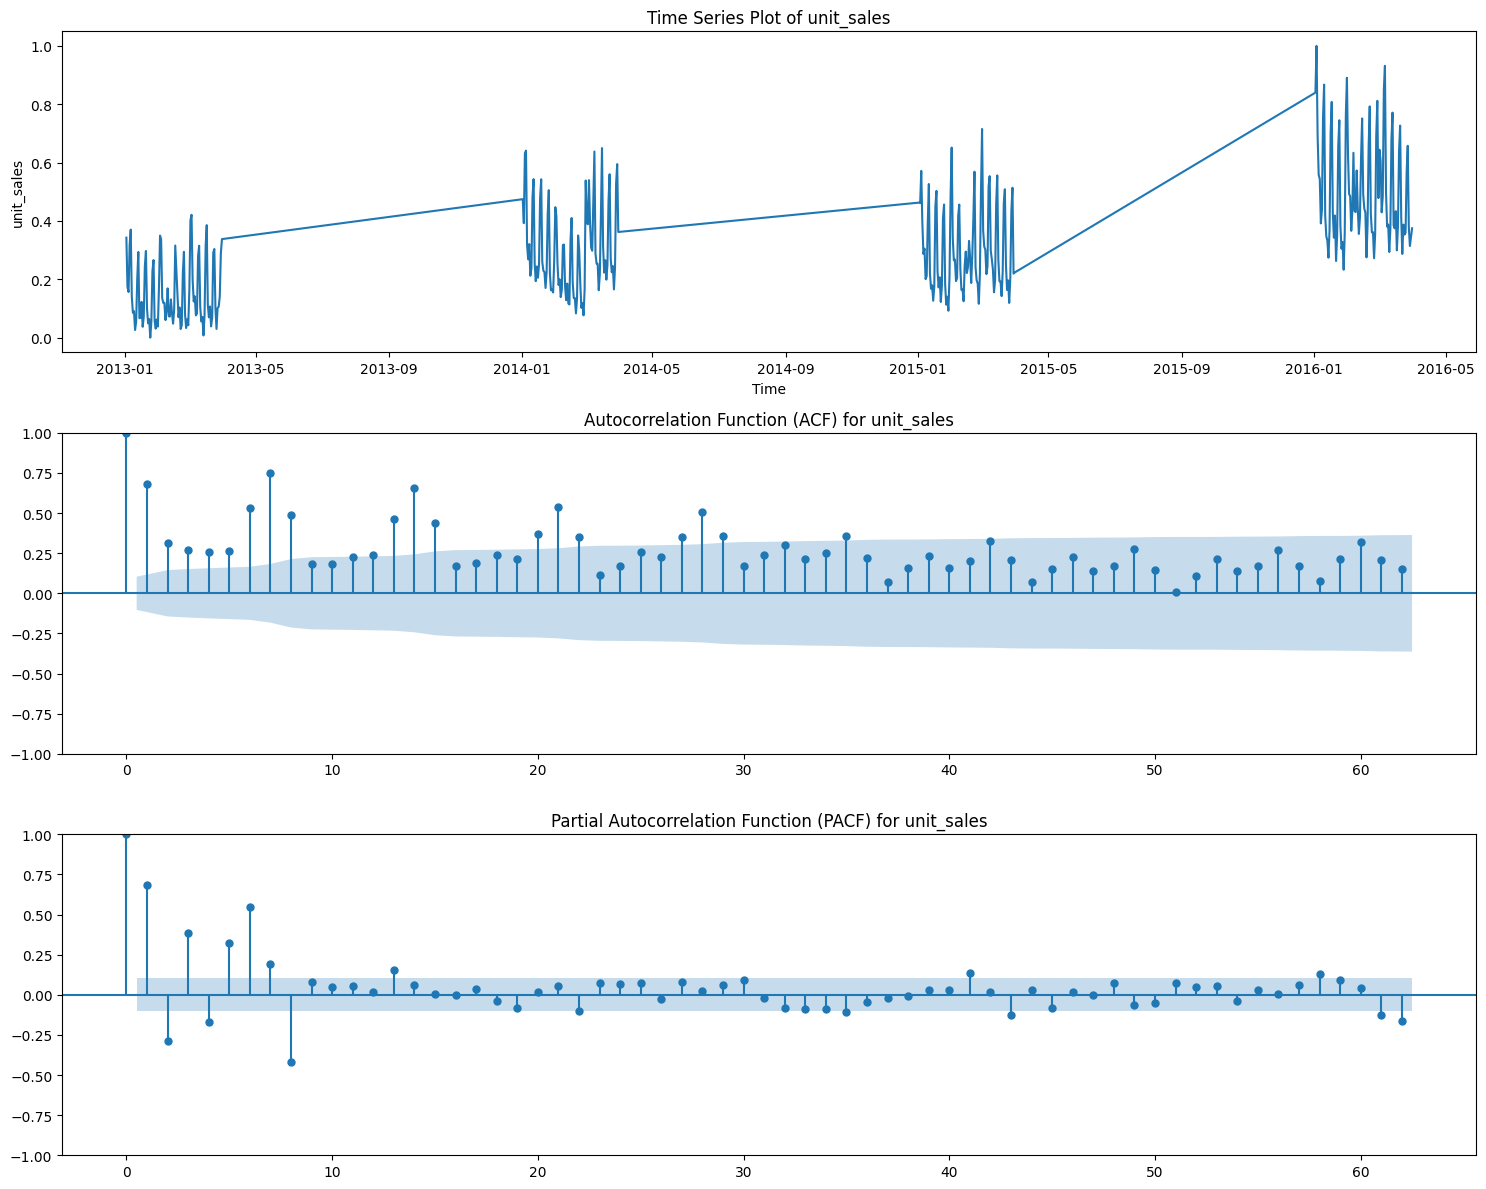

Seasonal Period:


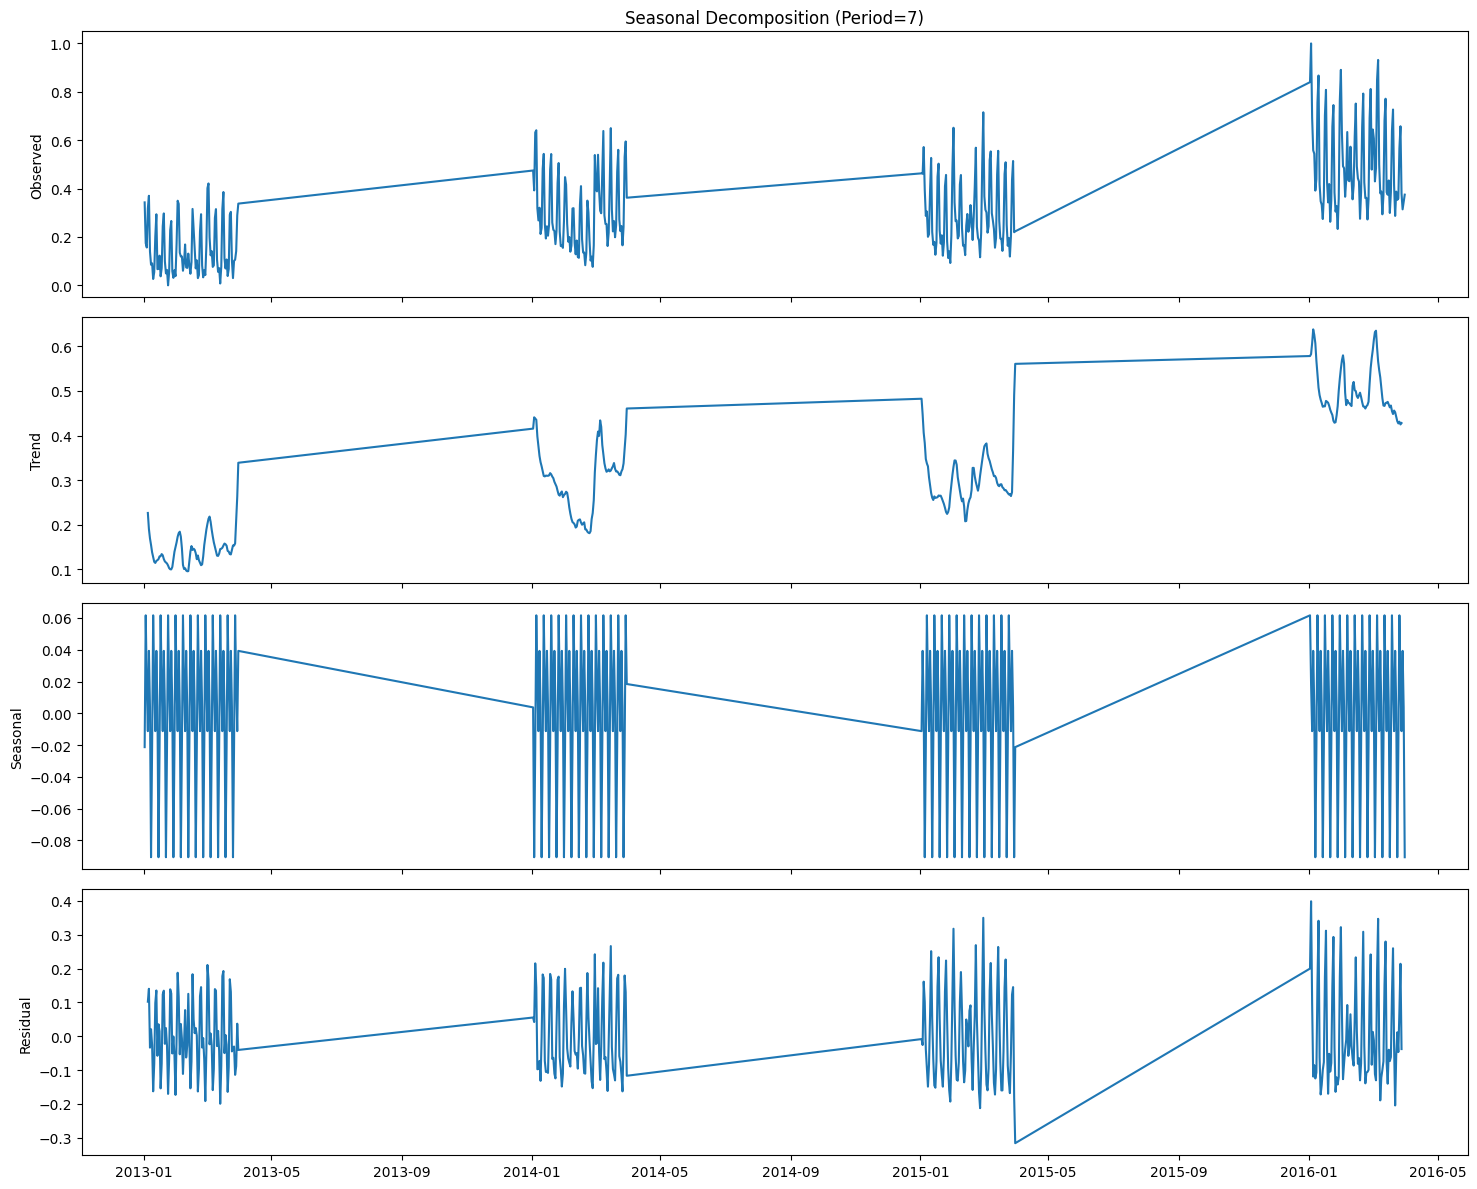

Plots for the seasonal_period: 7


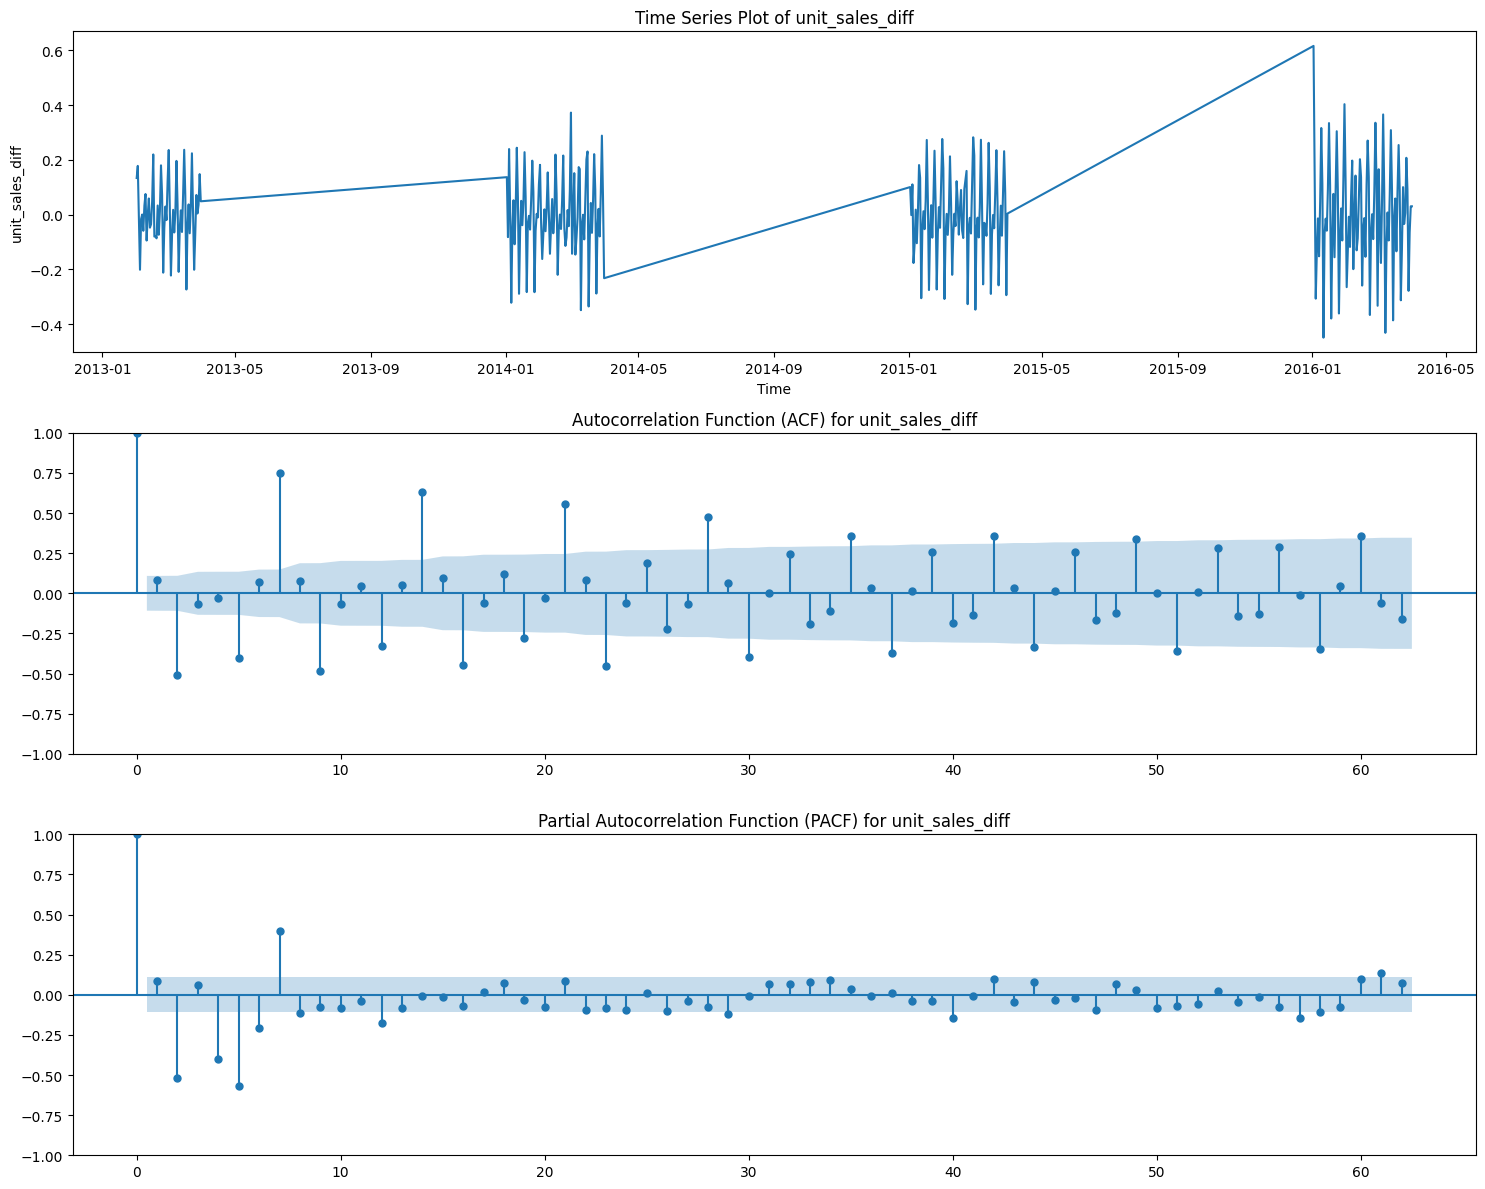

Seasonal Period:


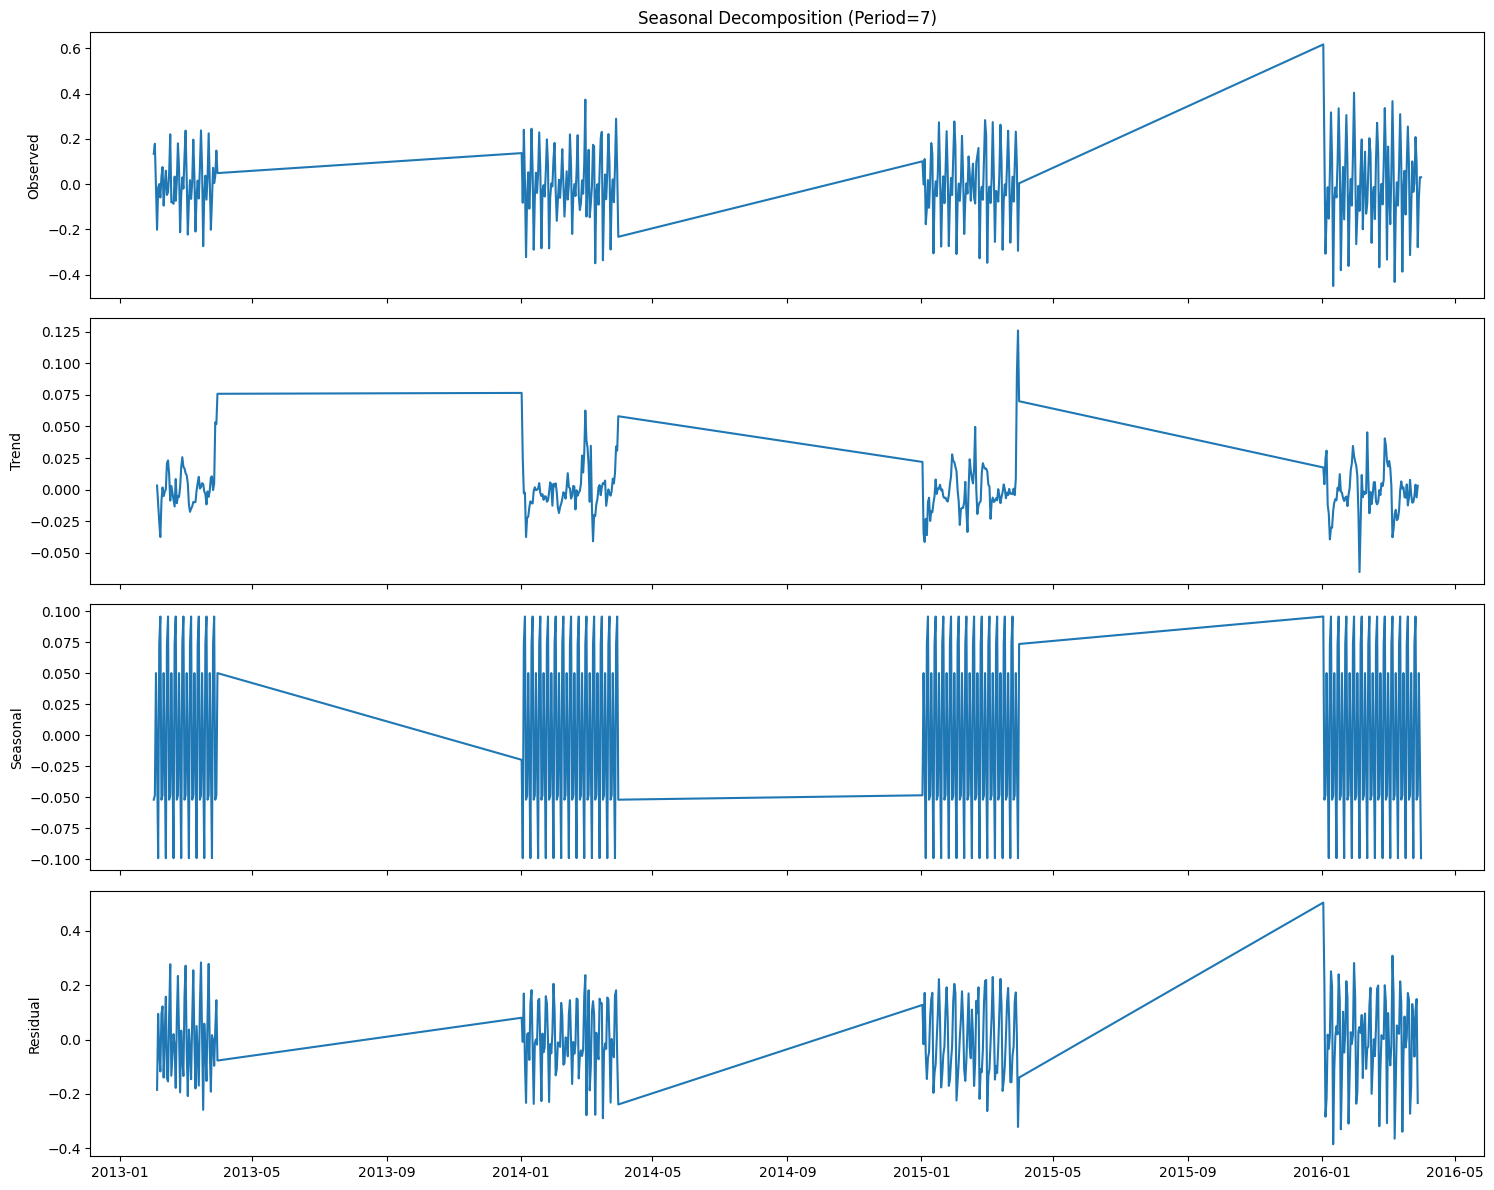

In [ ]:
plot_sarimax_diagnostics(train_df, 'date', 'unit_sales', lags=62, seasonal_period=7)
plot_sarimax_diagnostics(train_df.dropna(), 'date', 'unit_sales_diff', lags=62, seasonal_period=7)

Plots for the seasonal_period: 31


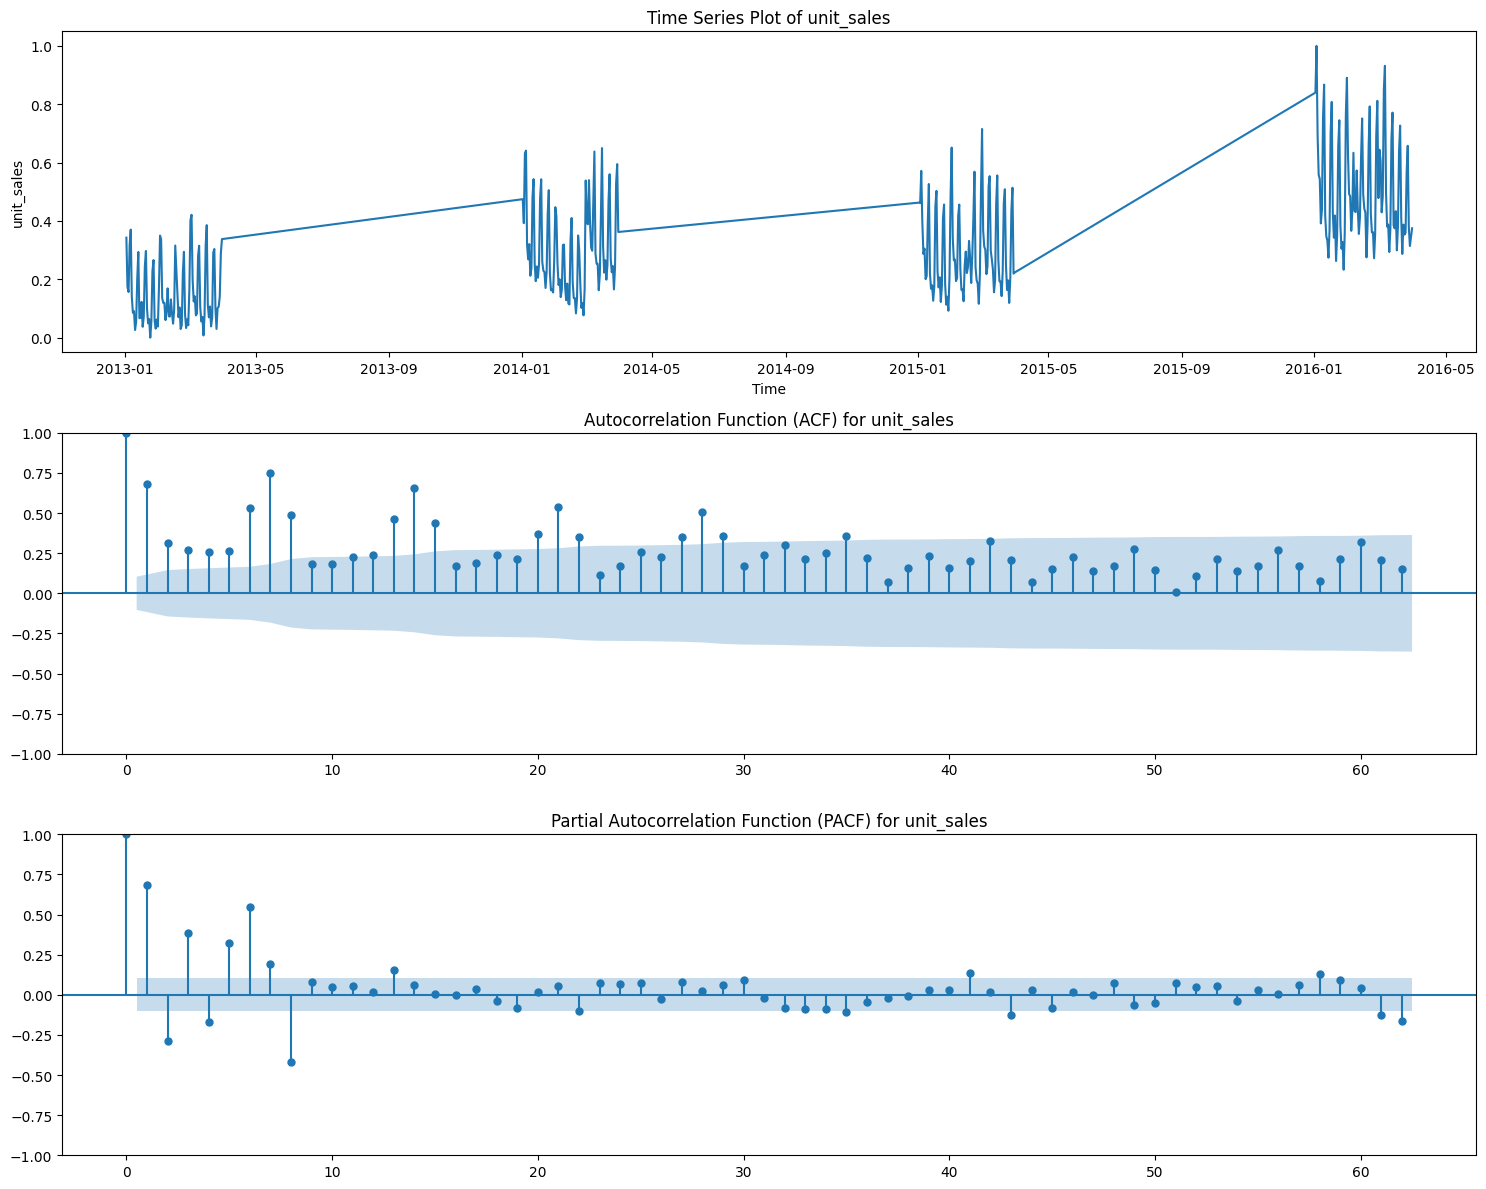

Seasonal Period:


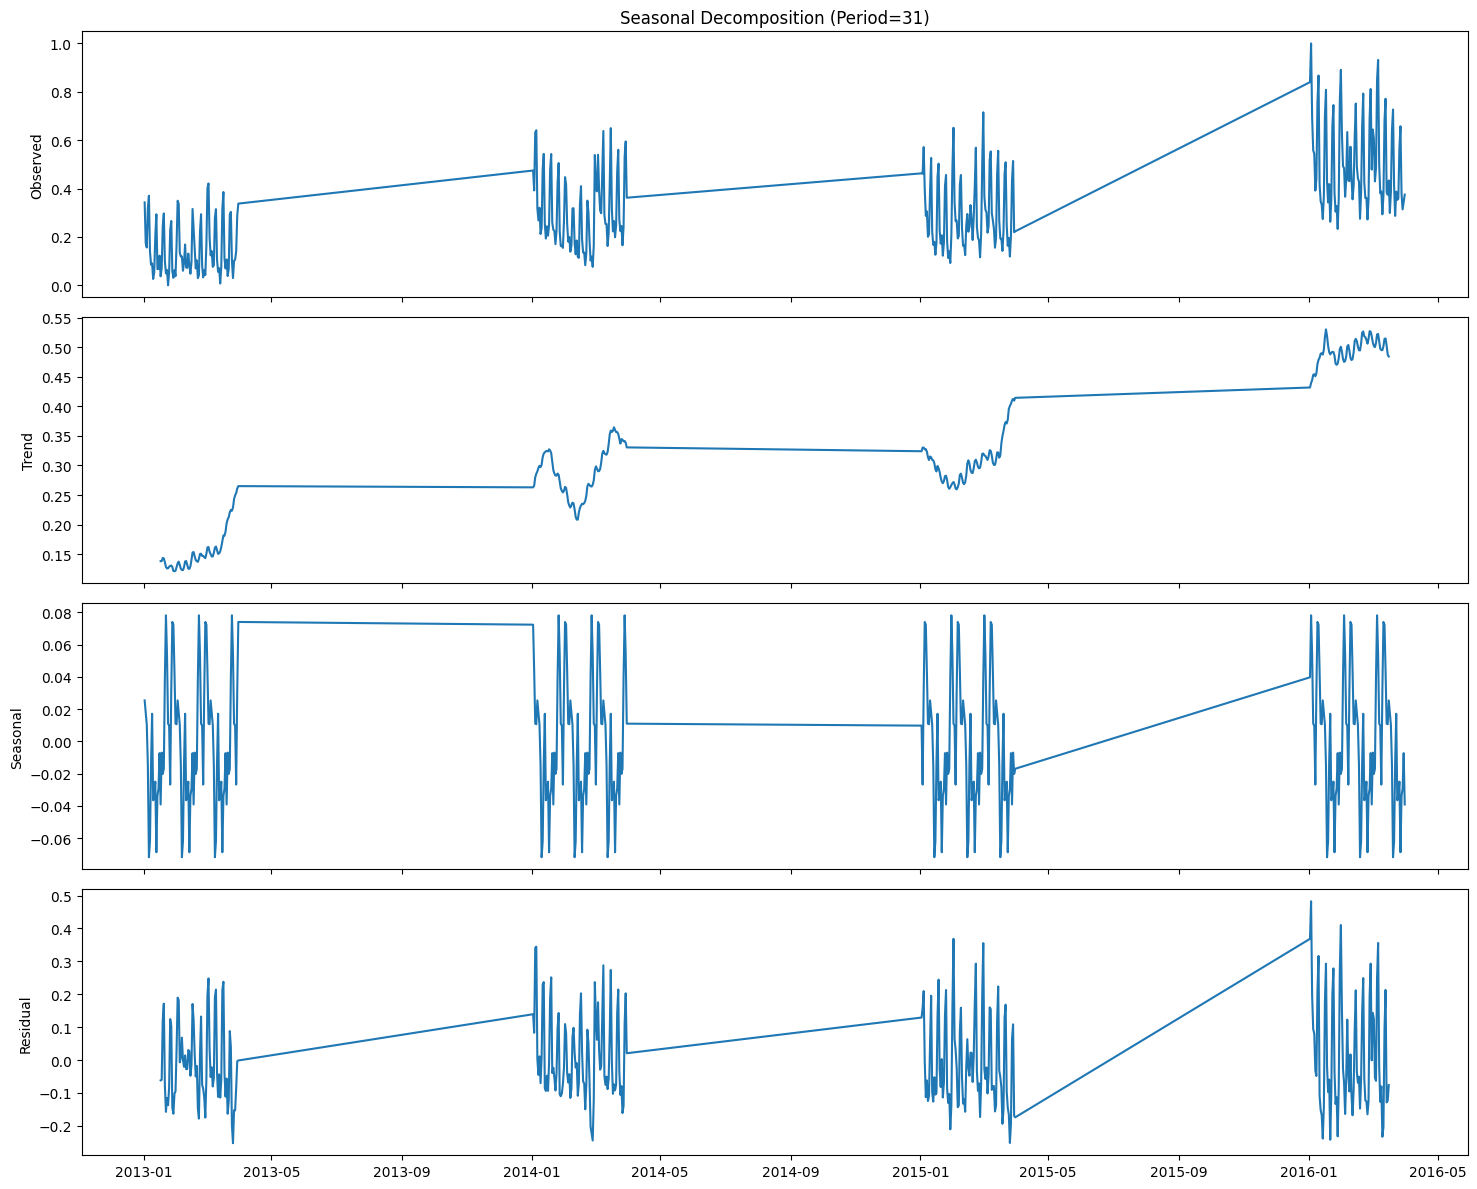

Plots for the seasonal_period: 31


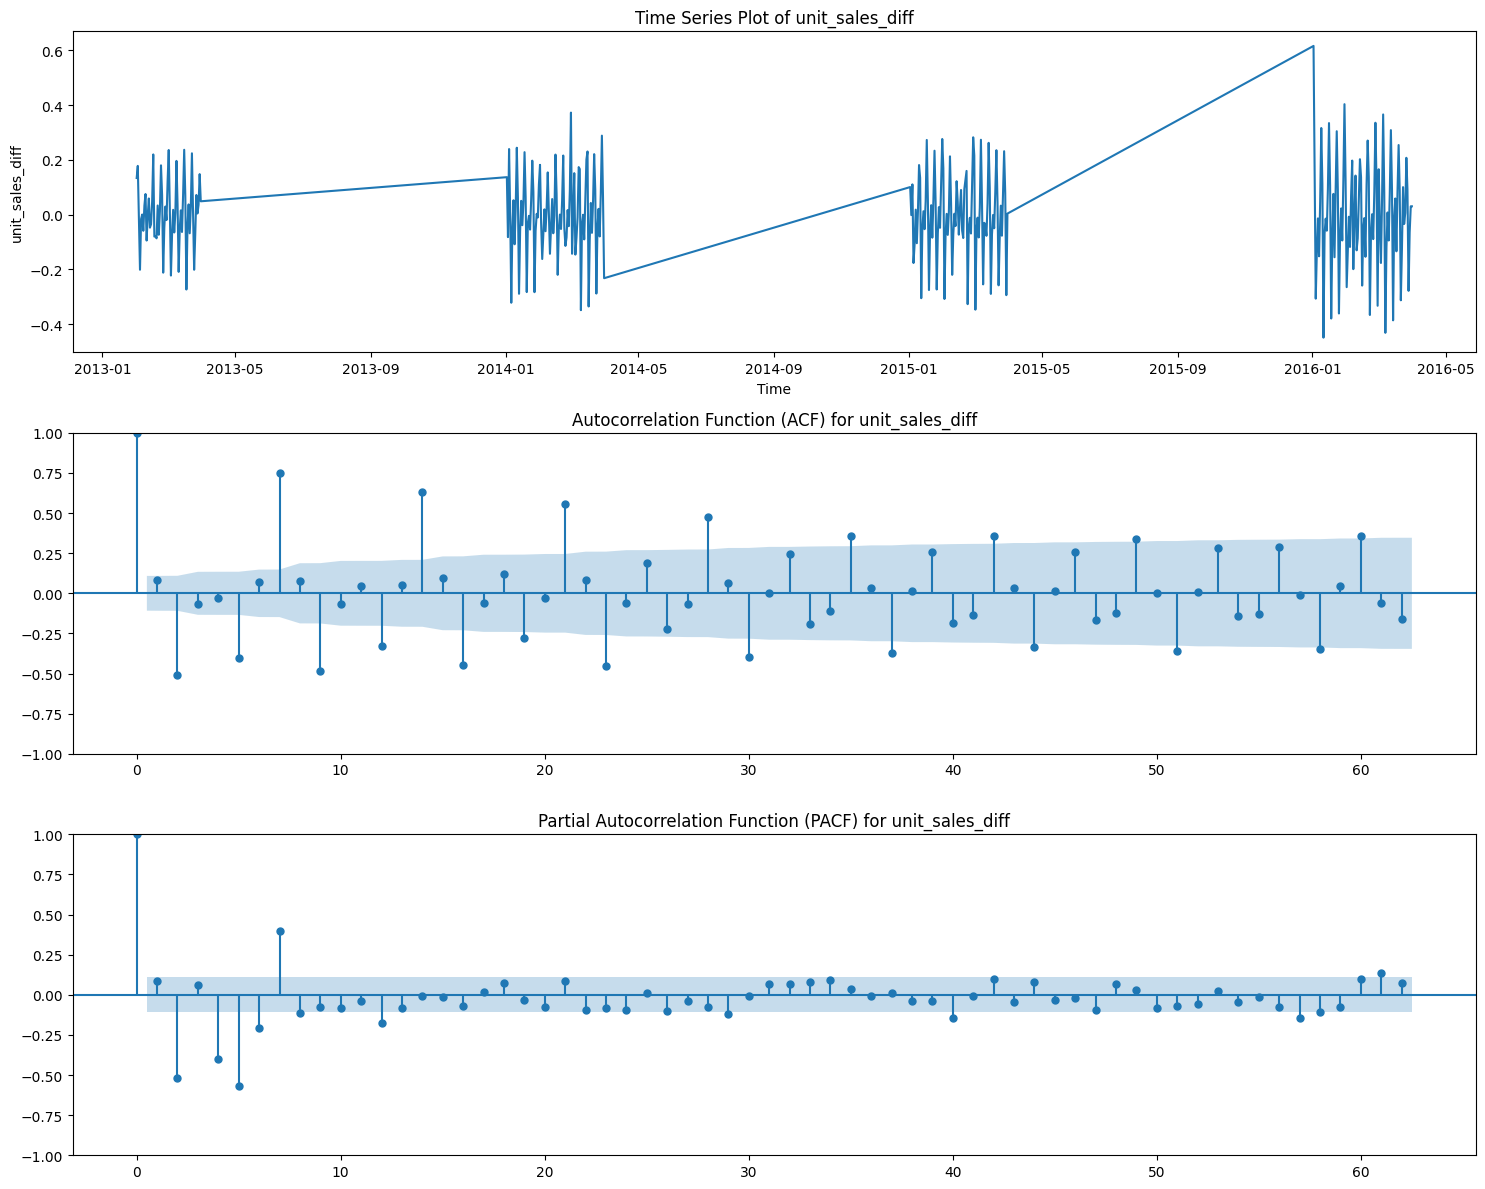

Seasonal Period:


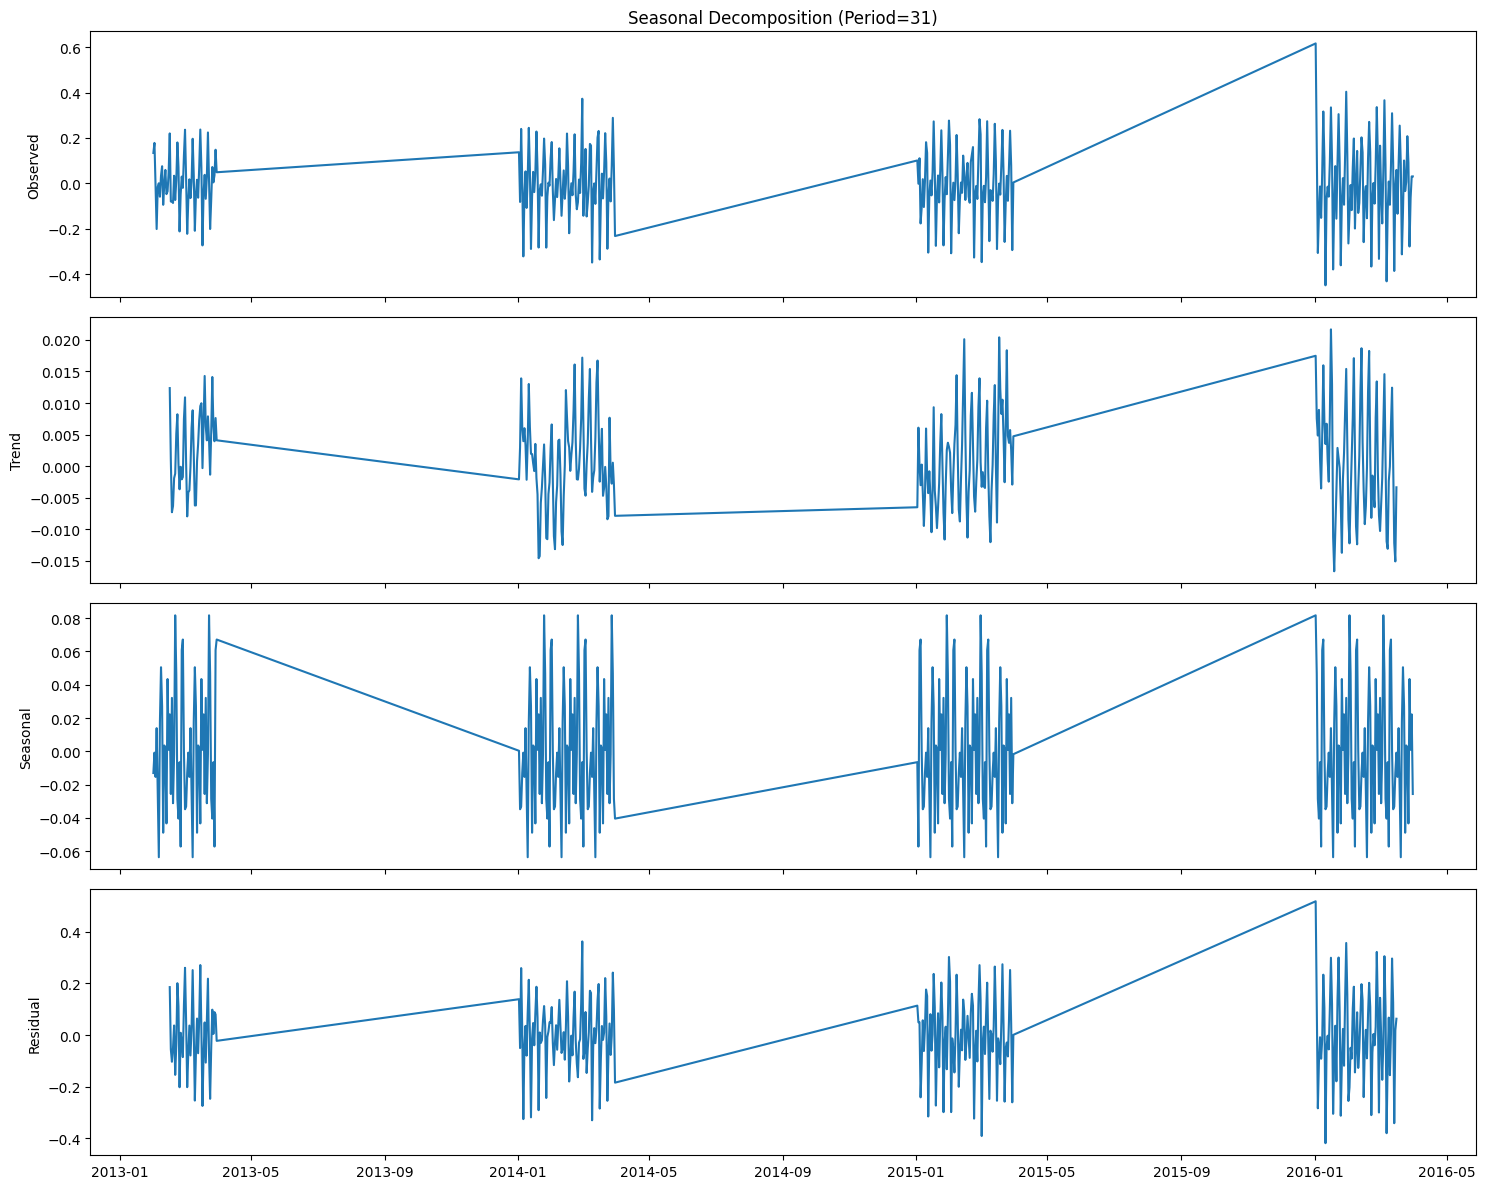

In [ ]:
plot_sarimax_diagnostics(train_df, 'date', 'unit_sales', lags=62, seasonal_period=31)
plot_sarimax_diagnostics(train_df.dropna(), 'date', 'unit_sales_diff', lags=62, seasonal_period=31)

The data shows that correlation can be found after differentiating. The plots of the seasonal period do not show a clear form of seasonality, yet the EDA in the previous steps does show seasonality, as well as the ACF and PACF plots - even if it is low. The problem is probably that the data has more than one seasonality.

### 3.1.3. XGBRegressor

In [ ]:
# no further processing needed

### 3.2.4. Prophet

In [ ]:
# no further preprocessing needed

## 3.2. Forcast

In [ ]:
forecasts = {}
# Exclude ID, date, target, and any diff columns that might not be in test
cols_to_exclude = ['id', 'date', 'unit_sales', 'unit_sales_diff']
lag_cols = [col for col in train_df.columns if '_lag_' in col]

# Get common features between train and test (excluding the above)
exog_cols_train = [col for col in train_df.columns if col not in cols_to_exclude]

exog_cols_test = [col for col in train_df.columns
             if col not in cols_to_exclude
             and col not in lag_cols
             and col in test_df.columns]
exog_cols_train = exog_cols_test
# Drop rows with NaN in exog columns and target
cols_to_check_train = exog_cols_train + ['unit_sales']
train_df = train_df.dropna(subset=cols_to_check_train)

cols_to_check_test = exog_cols_test
test_df = test_df.dropna(subset=cols_to_check_test)

In [ ]:
# Identify non-numeric columns
non_numeric_train = train_df[exog_cols_train].select_dtypes(exclude=['number']).columns.tolist()
non_numeric_test = test_df[exog_cols_test].select_dtypes(exclude=['number']).columns.tolist()

if non_numeric_train:
    print(f"⚠️ Non-numeric columns in train exog: {non_numeric_train}")
    exog_cols_train = [col for col in exog_cols_train if col not in non_numeric_train]

if non_numeric_test:
    print(f"⚠️ Non-numeric columns in test exog: {non_numeric_test}")
    exog_cols_test = [col for col in exog_cols_test if col not in non_numeric_test]

print(f"✓ Final train exog columns: {len(exog_cols_train)}")
print(f"✓ Final test exog columns: {len(exog_cols_test)}")

✓ Final train exog columns: 11
✓ Final test exog columns: 11


### 3.2.1. ARIMA

In [ ]:
forecasts['arima'] = run_arima_forecast(train_df, test_df, target_col='unit_sales', order=(5,1,5), exog_cols_train=exog_cols_train, exog_cols_test=exog_cols_test)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

### 3.2.2. SAMIRAX

In [ ]:
forecasts['samirax'] = run_sarimax_forecast(train_df, test_df, target_col='unit_sales', order=(5,1,5), seasonal_order=(1,1,0,7), exog_cols_train=exog_cols_train, exog_cols_test=exog_cols_test)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_

### 3.2.3. XGBRegressor

In [ ]:
# Run forecast
forecasts['xgboost'] = run_xgboost_forecast(train_df, test_df, target_col='unit_sales', exog_cols_train=exog_cols_train, exog_cols_test=exog_cols_test)

### 3.2.4. Prophet

In [ ]:
forecasts['prophet'] = run_prophet_forecast(train_df, test_df, time_col='date', target_col='unit_sales')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 3.3. Errors and Comparison

In [ ]:
models = ['arima', 'samirax', 'xgboost', 'prophet']
errors = {}
for model in models:
  errors[model] = calculate_regression_metrics(test_df['unit_sales'], forecasts[model])


In [ ]:
print(errors)

{'arima': {'MAE': np.float64(0.07963302579759399), 'MSE': np.float64(0.009477810206418427), 'RMSLE': np.float64(0.06195632166094896)}, 'samirax': {'MAE': np.float64(0.15217217739880357), 'MSE': np.float64(0.033200702341972574), 'RMSLE': np.float64(0.11502758824735172)}, 'xgboost': {'MAE': np.float32(0.06698775), 'MSE': np.float32(0.010806205), 'RMSLE': np.float32(0.0586731)}, 'prophet': {'MAE': np.float64(0.12213226086152563), 'MSE': np.float64(0.02094120320726395), 'RMSLE': np.float64(0.09207697676569813)}}


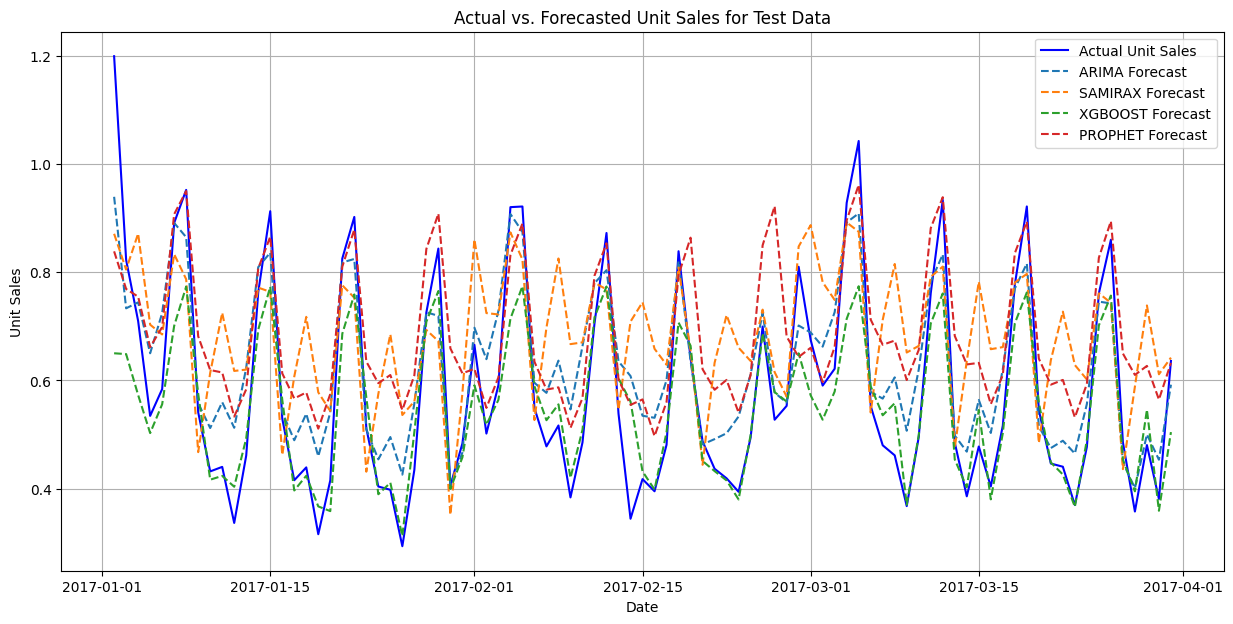

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(test_df['date'], test_df['unit_sales'], label='Actual Unit Sales', color='blue')

for model_name, forecast_series in forecasts.items():
    plt.plot(test_df['date'], forecast_series, label=f'{model_name.upper()} Forecast', linestyle='--')

plt.title('Actual vs. Forecasted Unit Sales for Test Data')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.grid(True)
plt.show()